In [1]:
#Refer to BERT model fine tune examples : https://github.com/google-research/bert

In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime

W1208 01:57:02.350674 140291304404736 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [3]:
hub.__version__

'0.4.0'

In [4]:
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

In [5]:
!pwd

/tf/notebooks/bert


In [6]:
import getpass
username = getpass.getuser()
print(username)

root


In [7]:
import os.path
homedir = os.path.expanduser("~")
print(homedir)

/root


In [8]:
import socket
hostname = socket.gethostname()
print(hostname)

v100-4


In [9]:
train = pd.read_csv('../chat_data/train/train_4i.in', header = None, names=['sentence'])
intent = pd.read_csv('../chat_data/train/train_4i.label', header = None, names=['intent'])
train['label'] = intent

In [10]:
train.head(5)

,sentence,label
0,hello,hello
1,so do i my account statement said that i got t...,refundstatus
2,you make it easy to contact,negfdbk
3,paypay says the two payments that i made were ...,refundstatus
4,hello,hello


In [15]:
test = pd.read_csv('../chat_data/test/test_4i.in', header = None, names=['sentence'])
test_intent = pd.read_csv('../chat_data/test/test_4i.label', header = None, names=['intent'])
test['label'] = test_intent

In [16]:
test.head(5)

,sentence,label
0,why do i need to wait for a pending partial re...,refundstatus
1,how do i make this chat box go away you suck b...,negfdbk
2,i received an email from paypal about a refund...,refundstatus
3,i sent money to a friend but then i cancelled ...,refundstatus
4,i was supposed to receive a refund from shein ...,refundstatus


In [17]:
# one hot encoding for labels
import json
tag_set = set()
for row in test['label'] :
    tag_set.add(row)
tag_map = dict()
i=0
for tag in tag_set :
    tag_map[tag] = i
    i=i+1
tag_map

{'agent': 3, 'hello': 2, 'negfdbk': 1, 'refundstatus': 0}

In [18]:
train_intent_count = {}

for key in tag_map:
    train_intent_count[key] =0

for intent in train['label'] :
    train_intent_count[intent]+=1

train_intent_count

{'agent': 457, 'hello': 125, 'negfdbk': 131, 'refundstatus': 940}

In [19]:
import numpy as np
def f(input):
    output = np.zeros(shape=(len(tag_set)), dtype=int)
    output[tag_map[input]] = 1;
    return output

train['onehot'] = train['label'].apply(f)
train['tag'] = train['label'].apply(lambda x : tag_map[x])

In [20]:
test['onehot'] = test['label'].apply(f)
test['tag'] = test['label'].apply(lambda x : tag_map[x])

In [21]:
train.head(5)

,sentence,label,onehot,tag
0,hello,hello,"[0, 0, 1, 0]",2
1,so do i my account statement said that i got t...,refundstatus,"[1, 0, 0, 0]",0
2,you make it easy to contact,negfdbk,"[0, 1, 0, 0]",1
3,paypay says the two payments that i made were ...,refundstatus,"[1, 0, 0, 0]",0
4,hello,hello,"[0, 0, 1, 0]",2


In [22]:
test.head(5)

,sentence,label,onehot,tag
0,why do i need to wait for a pending partial re...,refundstatus,"[1, 0, 0, 0]",0
1,how do i make this chat box go away you suck b...,negfdbk,"[0, 1, 0, 0]",1
2,i received an email from paypal about a refund...,refundstatus,"[1, 0, 0, 0]",0
3,i sent money to a friend but then i cancelled ...,refundstatus,"[1, 0, 0, 0]",0
4,i was supposed to receive a refund from shein ...,refundstatus,"[1, 0, 0, 0]",0


In [23]:
 # Use the InputExample class from BERT's run_classifier code to create examples from the data
train_InputExamples = train.apply(lambda x: bert.run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x['sentence'], 
                                                                   text_b = None, 
                                                                   label = x['tag']), axis = 1)

test_InputExamples = test.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x['sentence'], 
                                                                   text_b = None, 
                                                                   label = x['tag']), axis = 1)

Next, we need to preprocess our data so that it matches the data BERT was trained on. For this, we'll need to do a couple of things (but don't worry--this is also included in the Python library):


1. Lowercase our text (if we're using a BERT lowercase model)
2. Tokenize it (i.e. "sally says hi" -> ["sally", "says", "hi"])
3. Break words into WordPieces (i.e. "calling" -> ["call", "##ing"])
4. Map our words to indexes using a vocab file that BERT provides
5. Add special "CLS" and "SEP" tokens (see the [readme](https://github.com/google-research/bert))
6. Append "index" and "segment" tokens to each input (see the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf))

Happily, we don't have to worry about most of these details.




In [24]:
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_multi_cased_L-12_H-768_A-12/1"
#BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-24_H-1024_A-16/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      print(vocab_file)
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I1208 02:01:52.277489 140291304404736 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


b'/tmp/tfhub_modules/2e9b4b015e19c732663e0684f163c86f1deeee30/assets/vocab.txt'


In [25]:
!wc -l /tmp/tfhub_modules/5a395eafef2a37bd9fc55d7f6ae676d2a134a838/assets/vocab.txt

30522 /tmp/tfhub_modules/5a395eafef2a37bd9fc55d7f6ae676d2a134a838/assets/vocab.txt


In [26]:
label_list = test['tag'].unique()

In [27]:
label_list

array([0, 1, 3, 2])

In [28]:
# We'll set sequences to be at most 128 tokens long.
MAX_SEQ_LENGTH = 128
# Convert our train and test features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)
test_features = bert.run_classifier.convert_examples_to_features(test_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 1653


I1208 02:02:14.025879 140291304404736 tf_logging.py:115] Writing example 0 of 1653


INFO:tensorflow:*** Example ***


I1208 02:02:14.028357 140291304404736 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: None


I1208 02:02:14.029809 140291304404736 tf_logging.py:115] guid: None


INFO:tensorflow:tokens: [CLS] hell ##o [SEP]


I1208 02:02:14.030992 140291304404736 tf_logging.py:115] tokens: [CLS] hell ##o [SEP]


INFO:tensorflow:input_ids: 101 61694 10133 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:02:14.031999 140291304404736 tf_logging.py:115] input_ids: 101 61694 10133 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:02:14.033488 140291304404736 tf_logging.py:115] input_mask: 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:02:14.034896 140291304404736 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 2 (id = 3)


I1208 02:02:14.035963 140291304404736 tf_logging.py:115] label: 2 (id = 3)


INFO:tensorflow:*** Example ***


I1208 02:02:14.037642 140291304404736 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: None


I1208 02:02:14.038734 140291304404736 tf_logging.py:115] guid: None


INFO:tensorflow:tokens: [CLS] so do i my account statement said that i got the ref ##und in my balance said the amount is visible [SEP]


I1208 02:02:14.039734 140291304404736 tf_logging.py:115] tokens: [CLS] so do i my account statement said that i got the ref ##und in my balance said the amount is visible [SEP]


INFO:tensorflow:input_ids: 101 10380 10149 177 15127 23200 33311 12415 10189 177 19556 10105 48056 17242 10106 15127 40162 12415 10105 24074 10124 26877 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:02:14.040776 140291304404736 tf_logging.py:115] input_ids: 101 10380 10149 177 15127 23200 33311 12415 10189 177 19556 10105 48056 17242 10106 15127 40162 12415 10105 24074 10124 26877 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:02:14.041921 140291304404736 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:02:14.042967 140291304404736 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I1208 02:02:14.043981 140291304404736 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I1208 02:02:14.045276 140291304404736 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: None


I1208 02:02:14.046318 140291304404736 tf_logging.py:115] guid: None


INFO:tensorflow:tokens: [CLS] you make it easy to contact [SEP]


I1208 02:02:14.047404 140291304404736 tf_logging.py:115] tokens: [CLS] you make it easy to contact [SEP]


INFO:tensorflow:input_ids: 101 13028 13086 10271 44346 10114 20637 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:02:14.048468 140291304404736 tf_logging.py:115] input_ids: 101 13028 13086 10271 44346 10114 20637 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:02:14.049423 140291304404736 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:02:14.050276 140291304404736 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


I1208 02:02:14.051287 140291304404736 tf_logging.py:115] label: 1 (id = 1)


INFO:tensorflow:*** Example ***


I1208 02:02:14.052710 140291304404736 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: None


I1208 02:02:14.053679 140291304404736 tf_logging.py:115] guid: None


INFO:tensorflow:tokens: [CLS] pay ##pa ##y says the two payments that i made were ref ##unde ##d but i never got credit in my cc account [SEP]


I1208 02:02:14.066196 140291304404736 tf_logging.py:115] tokens: [CLS] pay ##pa ##y says the two payments that i made were ref ##unde ##d but i never got credit in my cc account [SEP]


INFO:tensorflow:input_ids: 101 16868 11359 10157 22153 10105 10551 99417 10189 177 11019 10309 48056 56354 10162 10473 177 14794 19556 37021 10106 15127 13774 23200 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:02:14.067241 140291304404736 tf_logging.py:115] input_ids: 101 16868 11359 10157 22153 10105 10551 99417 10189 177 11019 10309 48056 56354 10162 10473 177 14794 19556 37021 10106 15127 13774 23200 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:02:14.068480 140291304404736 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:02:14.069592 140291304404736 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I1208 02:02:14.070552 140291304404736 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I1208 02:02:14.071565 140291304404736 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: None


I1208 02:02:14.072513 140291304404736 tf_logging.py:115] guid: None


INFO:tensorflow:tokens: [CLS] hell ##o [SEP]


I1208 02:02:14.073574 140291304404736 tf_logging.py:115] tokens: [CLS] hell ##o [SEP]


INFO:tensorflow:input_ids: 101 61694 10133 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:02:14.074754 140291304404736 tf_logging.py:115] input_ids: 101 61694 10133 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:02:14.075780 140291304404736 tf_logging.py:115] input_mask: 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:02:14.076735 140291304404736 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 2 (id = 3)


I1208 02:02:14.077830 140291304404736 tf_logging.py:115] label: 2 (id = 3)


INFO:tensorflow:Writing example 0 of 487


I1208 02:02:14.522256 140291304404736 tf_logging.py:115] Writing example 0 of 487


INFO:tensorflow:*** Example ***


I1208 02:02:14.524852 140291304404736 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: None


I1208 02:02:14.526117 140291304404736 tf_logging.py:115] guid: None


INFO:tensorflow:tokens: [CLS] why do i need to wait for a pen ##ding partial ref ##und to be released at my bank since the ref ##und was issued by the selle ##r i purchase ##s items from the ref ##und need to clear his bank since he is the selle ##r issu ##ing a ref ##und to me [SEP]


I1208 02:02:14.527326 140291304404736 tf_logging.py:115] tokens: [CLS] why do i need to wait for a pen ##ding partial ref ##und to be released at my bank since the ref ##und was issued by the selle ##r i purchase ##s items from the ref ##und need to clear his bank since he is the selle ##r issu ##ing a ref ##und to me [SEP]


INFO:tensorflow:input_ids: 101 31237 10149 177 17367 10114 83279 10142 169 66558 13971 39474 48056 17242 10114 10347 11539 10160 15127 19423 11764 10105 48056 17242 10134 21694 10155 10105 22154 10129 177 37891 10107 34109 10188 10105 48056 17242 17367 10114 24866 10226 19423 11764 10261 10124 10105 22154 10129 28815 10230 169 48056 17242 10114 10911 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:02:14.528478 140291304404736 tf_logging.py:115] input_ids: 101 31237 10149 177 17367 10114 83279 10142 169 66558 13971 39474 48056 17242 10114 10347 11539 10160 15127 19423 11764 10105 48056 17242 10134 21694 10155 10105 22154 10129 177 37891 10107 34109 10188 10105 48056 17242 17367 10114 24866 10226 19423 11764 10261 10124 10105 22154 10129 28815 10230 169 48056 17242 10114 10911 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:02:14.529663 140291304404736 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:02:14.530784 140291304404736 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I1208 02:02:14.531854 140291304404736 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I1208 02:02:14.533200 140291304404736 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: None


I1208 02:02:14.534480 140291304404736 tf_logging.py:115] guid: None


INFO:tensorflow:tokens: [CLS] how do i make this chat box go away you su ##ck balls [SEP]


I1208 02:02:14.535620 140291304404736 tf_logging.py:115] tokens: [CLS] how do i make this chat box go away you su ##ck balls [SEP]


INFO:tensorflow:input_ids: 101 14796 10149 177 13086 10531 69338 21509 11783 14942 13028 10198 11263 88301 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:02:14.536747 140291304404736 tf_logging.py:115] input_ids: 101 14796 10149 177 13086 10531 69338 21509 11783 14942 13028 10198 11263 88301 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:02:14.537917 140291304404736 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:02:14.539027 140291304404736 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


I1208 02:02:14.540088 140291304404736 tf_logging.py:115] label: 1 (id = 1)


INFO:tensorflow:*** Example ***


I1208 02:02:14.541436 140291304404736 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: None


I1208 02:02:14.542817 140291304404736 tf_logging.py:115] guid: None


INFO:tensorflow:tokens: [CLS] i received an email from pay ##pal about a ref ##und but not showing in my ac ##cout [SEP]


I1208 02:02:14.543960 140291304404736 tf_logging.py:115] tokens: [CLS] i received an email from pay ##pal about a ref ##und but not showing in my ac ##cout [SEP]


INFO:tensorflow:input_ids: 101 177 12296 10151 79515 10188 16868 34935 10978 169 48056 17242 10473 10472 37501 10106 15127 13621 108449 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:02:14.545201 140291304404736 tf_logging.py:115] input_ids: 101 177 12296 10151 79515 10188 16868 34935 10978 169 48056 17242 10473 10472 37501 10106 15127 13621 108449 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:02:14.546409 140291304404736 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:02:14.547585 140291304404736 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I1208 02:02:14.548708 140291304404736 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I1208 02:02:14.550433 140291304404736 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: None


I1208 02:02:14.551559 140291304404736 tf_logging.py:115] guid: None


INFO:tensorflow:tokens: [CLS] i sent money to a friend but then i cancelled it and got a ref ##und i do not see it in my pay ##pal balance and i haven ##t received any money back to my bank account [SEP]


I1208 02:02:14.552598 140291304404736 tf_logging.py:115] tokens: [CLS] i sent money to a friend but then i cancelled it and got a ref ##und i do not see it in my pay ##pal balance and i haven ##t received any money back to my bank account [SEP]


INFO:tensorflow:input_ids: 101 177 14541 17920 10114 169 20104 10473 11059 177 60557 10271 10111 19556 169 48056 17242 177 10149 10472 12888 10271 10106 15127 16868 34935 40162 10111 177 65000 10123 12296 11178 17920 12014 10114 15127 19423 23200 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:02:14.553837 140291304404736 tf_logging.py:115] input_ids: 101 177 14541 17920 10114 169 20104 10473 11059 177 60557 10271 10111 19556 169 48056 17242 177 10149 10472 12888 10271 10106 15127 16868 34935 40162 10111 177 65000 10123 12296 11178 17920 12014 10114 15127 19423 23200 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:02:14.555101 140291304404736 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:02:14.556234 140291304404736 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I1208 02:02:14.557332 140291304404736 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I1208 02:02:14.559232 140291304404736 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: None


I1208 02:02:14.560327 140291304404736 tf_logging.py:115] guid: None


INFO:tensorflow:tokens: [CLS] i was supposed to receive a ref ##und from she ##in for the amount of to my pay ##pal account it has been days and the ref ##und was never posted to my account so i contacte ##d them they told me they submitted it on with ##t he ref ##und id [SEP]


I1208 02:02:14.561437 140291304404736 tf_logging.py:115] tokens: [CLS] i was supposed to receive a ref ##und from she ##in for the amount of to my pay ##pal account it has been days and the ref ##und was never posted to my account so i contacte ##d them they told me they submitted it on with ##t he ref ##und id [SEP]


INFO:tensorflow:input_ids: 101 177 10134 59516 10114 26286 169 48056 17242 10188 10833 10245 10142 10105 24074 10108 10114 15127 16868 34935 23200 10271 10393 10590 13990 10111 10105 48056 17242 10134 14794 51232 10114 15127 23200 10380 177 87471 10162 11345 10689 21937 10911 10689 58544 10271 10135 10169 10123 10261 48056 17242 12604 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:02:14.562571 140291304404736 tf_logging.py:115] input_ids: 101 177 10134 59516 10114 26286 169 48056 17242 10188 10833 10245 10142 10105 24074 10108 10114 15127 16868 34935 23200 10271 10393 10590 13990 10111 10105 48056 17242 10134 14794 51232 10114 15127 23200 10380 177 87471 10162 11345 10689 21937 10911 10689 58544 10271 10135 10169 10123 10261 48056 17242 12604 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:02:14.563832 140291304404736 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:02:14.565139 140291304404736 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I1208 02:02:14.566389 140291304404736 tf_logging.py:115] label: 0 (id = 0)


In [29]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  """Creates a classification model."""

  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]

  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)


In [30]:
# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
#        f1_score = tf.contrib.metrics.f1_score(
#            label_ids,
#            predicted_labels)
#        auc = tf.metrics.auc(
#            label_ids,
#            predicted_labels)
#        recall = tf.metrics.recall(
#            label_ids,
#            predicted_labels)
#        precision = tf.metrics.precision(
#            label_ids,
#            predicted_labels) 
#        true_pos = tf.metrics.true_positives(
#            label_ids,
#            predicted_labels)
#        true_neg = tf.metrics.true_negatives(
#            label_ids,
#            predicted_labels)   
#        false_pos = tf.metrics.false_positives(
#            label_ids,
#            predicted_labels)  
#        false_neg = tf.metrics.false_negatives(
#            label_ids,
#            predicted_labels)
        return {
            "eval_accuracy": accuracy,
#            "f1_score": f1_score,
#            "auc": auc,
#            "precision": precision,
#            "recall": recall,
#            "true_positives": true_pos,
#            "true_negatives": true_neg,
#            "false_positives": false_pos,
#            "false_negatives": false_neg
        }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn


In [31]:
# Compute train and warmup steps from batch size
# These hyperparameters are copied from this colab notebook (https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb)
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 15.0
# Warmup is a period of time where hte learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 500
SAVE_SUMMARY_STEPS = 100

In [32]:
# Compute # train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

In [33]:
OUTPUT_DIR='MultiLingual_1'

# Specify outpit directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [34]:
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})


INFO:tensorflow:Using config: {'_device_fn': None, '_master': '', '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_every_n_hours': 10000, '_save_checkpoints_steps': 500, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9748301e10>, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_eval_distribute': None, '_global_id_in_cluster': 0, '_num_ps_replicas': 0, '_save_checkpoints_secs': None, '_protocol': None, '_model_dir': 'MultiLingual_1', '_tf_random_seed': None, '_is_chief': True, '_log_step_count_steps': 100, '_service': None, '_num_worker_replicas': 1, '_save_summary_steps': 100, '_task_id': 0, '_experimental_distribute': None, '_train_distribute': None, '_evaluation_master': ''}


I1208 02:02:20.755651 140291304404736 tf_logging.py:115] Using config: {'_device_fn': None, '_master': '', '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_every_n_hours': 10000, '_save_checkpoints_steps': 500, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9748301e10>, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_eval_distribute': None, '_global_id_in_cluster': 0, '_num_ps_replicas': 0, '_save_checkpoints_secs': None, '_protocol': None, '_model_dir': 'MultiLingual_1', '_tf_random_seed': None, '_is_chief': True, '_log_step_count_steps': 100, '_service': None, '_num_worker_replicas': 1, '_save_summary_steps': 100, '_task_id': 0, '_experimental_distribute': None, '_train_distribute': None, '_evaluation_master': ''}


In [35]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

In [36]:
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)


INFO:tensorflow:Calling model_fn.


I1208 02:02:23.087837 140291304404736 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I1208 02:02:26.991501 140291304404736 tf_logging.py:115] Saver not created because there are no variables in the graph to restore
/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


I1208 02:02:36.714093 140291304404736 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I1208 02:02:36.719412 140291304404736 tf_logging.py:115] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I1208 02:02:41.705031 140291304404736 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I1208 02:02:49.247523 140291304404736 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I1208 02:02:49.474353 140291304404736 tf_logging.py:115] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into MultiLingual_1/model.ckpt.


I1208 02:02:59.590859 140291304404736 tf_logging.py:115] Saving checkpoints for 0 into MultiLingual_1/model.ckpt.


INFO:tensorflow:loss = 1.4050412, step = 0


I1208 02:03:15.930740 140291304404736 tf_logging.py:115] loss = 1.4050412, step = 0


INFO:tensorflow:global_step/sec: 1.78175


I1208 02:04:12.054737 140291304404736 tf_logging.py:115] global_step/sec: 1.78175


INFO:tensorflow:loss = 0.03447245, step = 100 (56.127 sec)


I1208 02:04:12.057409 140291304404736 tf_logging.py:115] loss = 0.03447245, step = 100 (56.127 sec)


INFO:tensorflow:global_step/sec: 2.37541


I1208 02:04:54.152678 140291304404736 tf_logging.py:115] global_step/sec: 2.37541


INFO:tensorflow:loss = 0.013099155, step = 200 (42.098 sec)


I1208 02:04:54.155072 140291304404736 tf_logging.py:115] loss = 0.013099155, step = 200 (42.098 sec)


INFO:tensorflow:global_step/sec: 2.37308


I1208 02:05:36.291950 140291304404736 tf_logging.py:115] global_step/sec: 2.37308


INFO:tensorflow:loss = 0.0025658202, step = 300 (42.139 sec)


I1208 02:05:36.294123 140291304404736 tf_logging.py:115] loss = 0.0025658202, step = 300 (42.139 sec)


INFO:tensorflow:global_step/sec: 2.37907


I1208 02:06:18.325211 140291304404736 tf_logging.py:115] global_step/sec: 2.37907


INFO:tensorflow:loss = 0.002443693, step = 400 (42.034 sec)


I1208 02:06:18.327901 140291304404736 tf_logging.py:115] loss = 0.002443693, step = 400 (42.034 sec)


INFO:tensorflow:Saving checkpoints for 500 into MultiLingual_1/model.ckpt.


I1208 02:07:00.094411 140291304404736 tf_logging.py:115] Saving checkpoints for 500 into MultiLingual_1/model.ckpt.


INFO:tensorflow:global_step/sec: 2.1802


I1208 02:07:04.192584 140291304404736 tf_logging.py:115] global_step/sec: 2.1802


INFO:tensorflow:loss = 0.0012418361, step = 500 (45.867 sec)


I1208 02:07:04.194899 140291304404736 tf_logging.py:115] loss = 0.0012418361, step = 500 (45.867 sec)


INFO:tensorflow:global_step/sec: 2.37706


I1208 02:07:46.261416 140291304404736 tf_logging.py:115] global_step/sec: 2.37706


INFO:tensorflow:loss = 0.019472806, step = 600 (42.069 sec)


I1208 02:07:46.263810 140291304404736 tf_logging.py:115] loss = 0.019472806, step = 600 (42.069 sec)


INFO:tensorflow:global_step/sec: 2.37641


I1208 02:08:28.341844 140291304404736 tf_logging.py:115] global_step/sec: 2.37641


INFO:tensorflow:loss = 0.0012774678, step = 700 (42.081 sec)


I1208 02:08:28.344493 140291304404736 tf_logging.py:115] loss = 0.0012774678, step = 700 (42.081 sec)


INFO:tensorflow:Saving checkpoints for 774 into MultiLingual_1/model.ckpt.


I1208 02:08:59.243386 140291304404736 tf_logging.py:115] Saving checkpoints for 774 into MultiLingual_1/model.ckpt.


INFO:tensorflow:Loss for final step: 0.0010605514.


I1208 02:09:04.834347 140291304404736 tf_logging.py:115] Loss for final step: 0.0010605514.


In [37]:
def serving_input_receiver_fn():
    """Serving input_fn that builds features from placeholders

    Returns
    -------
    tf.estimator.export.ServingInputReceiver
    """
    input_ids = tf.placeholder(dtype=tf.int32, shape=[None, 128], name='input_ids')
    input_mask = tf.placeholder(dtype=tf.int32, shape=[None, 128], name='input_mask')
    segment_ids = tf.placeholder(dtype=tf.int32, shape=[None, 128], name='segment_ids')
    label_ids = tf.placeholder(dtype=tf.int32, shape=[None], name='label_ids')
    
    receiver_tensors = {'input_ids': input_ids, 'input_mask': input_mask,'segment_ids': segment_ids, 'label_ids': label_ids}
    return tf.estimator.export.ServingInputReceiver(receiver_tensors, receiver_tensors)

estimator.export_saved_model('saved_model', serving_input_receiver_fn)

INFO:tensorflow:Calling model_fn.


I1208 02:09:04.904978 140291304404736 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I1208 02:09:09.440740 140291304404736 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I1208 02:09:09.636333 140291304404736 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']


I1208 02:09:09.642189 140291304404736 tf_logging.py:115] Signatures INCLUDED in export for Predict: ['serving_default']


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


I1208 02:09:09.643520 140291304404736 tf_logging.py:115] Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


I1208 02:09:09.644698 140291304404736 tf_logging.py:115] Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


I1208 02:09:09.646655 140291304404736 tf_logging.py:115] Signatures INCLUDED in export for Eval: None


INFO:tensorflow:Signatures INCLUDED in export for Train: None


I1208 02:09:09.647888 140291304404736 tf_logging.py:115] Signatures INCLUDED in export for Train: None


INFO:tensorflow:Restoring parameters from MultiLingual_1/model.ckpt-774


I1208 02:09:09.979902 140291304404736 tf_logging.py:115] Restoring parameters from MultiLingual_1/model.ckpt-774


Instructions for updating:
Pass your op to the equivalent parameter main_op instead.


W1208 02:09:10.865279 140291304404736 tf_logging.py:125] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/estimator/estimator.py:1044: calling SavedModelBuilder.add_meta_graph_and_variables (from tensorflow.python.saved_model.builder_impl) with legacy_init_op is deprecated and will be removed in a future version.
Instructions for updating:
Pass your op to the equivalent parameter main_op instead.


INFO:tensorflow:Assets added to graph.


I1208 02:09:10.867773 140291304404736 tf_logging.py:115] Assets added to graph.


INFO:tensorflow:Assets written to: saved_model/temp-b'1575770944'/assets


I1208 02:09:10.870616 140291304404736 tf_logging.py:115] Assets written to: saved_model/temp-b'1575770944'/assets


INFO:tensorflow:SavedModel written to: saved_model/temp-b'1575770944'/saved_model.pb


I1208 02:09:12.936925 140291304404736 tf_logging.py:115] SavedModel written to: saved_model/temp-b'1575770944'/saved_model.pb


b'saved_model/1575770944'

In [38]:
test_input_fn = run_classifier.input_fn_builder(
    features=test_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [39]:
estimator.evaluate(input_fn=test_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


I1208 02:09:14.643864 140291304404736 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I1208 02:09:18.908442 140291304404736 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I1208 02:09:28.678104 140291304404736 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-12-08-02:09:28


I1208 02:09:28.707190 140291304404736 tf_logging.py:115] Starting evaluation at 2019-12-08-02:09:28


INFO:tensorflow:Graph was finalized.


I1208 02:09:30.802595 140291304404736 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Restoring parameters from MultiLingual_1/model.ckpt-774


I1208 02:09:30.809504 140291304404736 tf_logging.py:115] Restoring parameters from MultiLingual_1/model.ckpt-774


INFO:tensorflow:Running local_init_op.


I1208 02:09:33.011637 140291304404736 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I1208 02:09:33.230017 140291304404736 tf_logging.py:115] Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2019-12-08-02:09:37


I1208 02:09:37.384401 140291304404736 tf_logging.py:115] Finished evaluation at 2019-12-08-02:09:37


INFO:tensorflow:Saving dict for global step 774: eval_accuracy = 0.94045174, global_step = 774, loss = 0.36554658


I1208 02:09:37.386774 140291304404736 tf_logging.py:115] Saving dict for global step 774: eval_accuracy = 0.94045174, global_step = 774, loss = 0.36554658


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 774: MultiLingual_1/model.ckpt-774


I1208 02:09:40.409099 140291304404736 tf_logging.py:115] Saving 'checkpoint_path' summary for global step 774: MultiLingual_1/model.ckpt-774


{'eval_accuracy': 0.94045174, 'global_step': 774, 'loss': 0.36554658}

In [40]:
def getPrediction(in_sentences):
  labels = label_list
  input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_sentences] # here, "" is just a dummy label
  input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
  
  predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)
  return [(sentence, prediction['probabilities'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)]




In [41]:
pred_sentences = [
    "我将钱寄给了一位朋友，但是后来我取消了这笔钱并获得了退款，但我的贝宝余额中没有看到这笔钱，而且我还没有收到任何退款到我的银行帐户中",
  "hello",
  "你好",
  "Hallo",
  "வணக்கம்"
]

In [42]:
def column(matrix, i):
    return [row[i] for row in matrix]

In [43]:
predictions = getPrediction(pred_sentences)

INFO:tensorflow:Writing example 0 of 5


I1208 02:09:40.461317 140291304404736 tf_logging.py:115] Writing example 0 of 5


INFO:tensorflow:*** Example ***


I1208 02:09:40.463657 140291304404736 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I1208 02:09:40.464778 140291304404736 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] 我 将 钱 寄 给 了 一 位 朋 友 ， 但 是 后 来 我 取 消 了 这 笔 钱 并 获 得 了 退 款 ， 但 我 的 贝 宝 余 额 中 没 有 看 到 这 笔 钱 ， 而 且 我 还 没 有 收 到 任 何 退 款 到 我 的 银 行 帐 户 中 [SEP]


I1208 02:09:40.465997 140291304404736 tf_logging.py:115] tokens: [CLS] 我 将 钱 寄 给 了 一 位 朋 友 ， 但 是 后 来 我 取 消 了 这 笔 钱 并 获 得 了 退 款 ， 但 我 的 贝 宝 余 额 中 没 有 看 到 这 笔 钱 ， 而 且 我 还 没 有 收 到 任 何 退 款 到 我 的 银 行 帐 户 中 [SEP]


INFO:tensorflow:input_ids: 101 3976 3451 8060 3415 6342 2146 2072 2246 4462 2731 10064 2243 4380 2775 4501 3976 2737 5010 2146 7700 6055 8060 3643 6779 3775 2146 7718 4780 10064 2243 3976 5718 7473 3391 2256 8442 2104 4917 4461 5765 2555 7700 6055 8060 10064 6459 2085 3976 7699 4917 4461 4280 2555 2212 2253 7718 4780 2555 3976 5718 8084 7069 3606 3994 2104 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:09:40.466998 140291304404736 tf_logging.py:115] input_ids: 101 3976 3451 8060 3415 6342 2146 2072 2246 4462 2731 10064 2243 4380 2775 4501 3976 2737 5010 2146 7700 6055 8060 3643 6779 3775 2146 7718 4780 10064 2243 3976 5718 7473 3391 2256 8442 2104 4917 4461 5765 2555 7700 6055 8060 10064 6459 2085 3976 7699 4917 4461 4280 2555 2212 2253 7718 4780 2555 3976 5718 8084 7069 3606 3994 2104 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:09:40.467938 140291304404736 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:09:40.469136 140291304404736 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I1208 02:09:40.470273 140291304404736 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I1208 02:09:40.471595 140291304404736 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I1208 02:09:40.472640 140291304404736 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] hell ##o [SEP]


I1208 02:09:40.473651 140291304404736 tf_logging.py:115] tokens: [CLS] hell ##o [SEP]


INFO:tensorflow:input_ids: 101 61694 10133 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:09:40.474648 140291304404736 tf_logging.py:115] input_ids: 101 61694 10133 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:09:40.475622 140291304404736 tf_logging.py:115] input_mask: 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:09:40.476722 140291304404736 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I1208 02:09:40.477761 140291304404736 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I1208 02:09:40.478864 140291304404736 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I1208 02:09:40.479876 140291304404736 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] 你 好 [SEP]


I1208 02:09:40.481127 140291304404736 tf_logging.py:115] tokens: [CLS] 你 好 [SEP]


INFO:tensorflow:input_ids: 101 2262 3240 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:09:40.482186 140291304404736 tf_logging.py:115] input_ids: 101 2262 3240 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:09:40.483074 140291304404736 tf_logging.py:115] input_mask: 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:09:40.484083 140291304404736 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I1208 02:09:40.485074 140291304404736 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I1208 02:09:40.486213 140291304404736 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I1208 02:09:40.487277 140291304404736 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] Hall ##o [SEP]


I1208 02:09:40.488292 140291304404736 tf_logging.py:115] tokens: [CLS] Hall ##o [SEP]


INFO:tensorflow:input_ids: 101 11763 10133 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:09:40.489377 140291304404736 tf_logging.py:115] input_ids: 101 11763 10133 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:09:40.490345 140291304404736 tf_logging.py:115] input_mask: 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:09:40.491646 140291304404736 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I1208 02:09:40.492649 140291304404736 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I1208 02:09:40.493787 140291304404736 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I1208 02:09:40.494765 140291304404736 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] வ ##ண ##க்கம் [SEP]


I1208 02:09:40.495764 140291304404736 tf_logging.py:115] tokens: [CLS] வ ##ண ##க்கம் [SEP]


INFO:tensorflow:input_ids: 101 1170 40397 34767 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:09:40.496784 140291304404736 tf_logging.py:115] input_ids: 101 1170 40397 34767 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:09:40.497869 140291304404736 tf_logging.py:115] input_mask: 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:09:40.498901 140291304404736 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I1208 02:09:40.499764 140291304404736 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:Calling model_fn.


I1208 02:09:40.536341 140291304404736 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I1208 02:09:45.130460 140291304404736 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I1208 02:09:45.320489 140291304404736 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I1208 02:09:46.149155 140291304404736 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Restoring parameters from MultiLingual_1/model.ckpt-774


I1208 02:09:46.153906 140291304404736 tf_logging.py:115] Restoring parameters from MultiLingual_1/model.ckpt-774


INFO:tensorflow:Running local_init_op.


I1208 02:09:46.963809 140291304404736 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I1208 02:09:47.040229 140291304404736 tf_logging.py:115] Done running local_init_op.


In [44]:
tag_map

{'agent': 3, 'hello': 2, 'negfdbk': 1, 'refundstatus': 0}

In [45]:
tag_reverse_map = {}
for k,v in tag_map.items():
    tag_reverse_map[v] = k

In [46]:
tag_reverse_map

{0: 'refundstatus', 1: 'negfdbk', 2: 'hello', 3: 'agent'}

In [47]:
def getResultFromPred(predictions):
    result = []
    for row in predictions:
        result.append(row[2])
    return result

In [48]:
def eval(actual, pred, labels):
    accu=0
    tp=collections.defaultdict(lambda : 0)
    fp=collections.defaultdict(lambda : 0)
    fn=collections.defaultdict(lambda : 0)
    precision=collections.defaultdict(lambda : 0)
    recall=collections.defaultdict(lambda : 0)

    confusion_matrix = collections.defaultdict(lambda: collections.defaultdict(lambda:0))
    for i,val in enumerate(actual):
        if val==pred[i]:
            accu = accu + 1
            tp[val]=tp[val]+1
        else:
            fp[pred[i]] = fp[pred[i]]+1
            fn[val] = fn[val] + 1

        confusion_matrix[val][pred[i]] = confusion_matrix[val][pred[i]] + 1

    for tag in labels:
        if (tp[tag] + fp[tag]) != 0:
            precision[tag] = tp[tag]/(tp[tag] + fp[tag])
            recall[tag] = tp[tag] / (tp[tag] + fn[tag])
    return (accu/len(actual), tp, fp, fn, precision, recall, confusion_matrix)


In [57]:
test_zh = pd.read_csv('../chat_data/test/chatbot_v2_test_zh.txt', header = None, sep="%$#@D", names=['sentence'])
test_de = pd.read_csv('../chat_data/test/chatbot_v2_test_de.txt', header = None, sep="%$#@D",names=['sentence'])
test_fr = pd.read_csv('../chat_data/test/chatbot_v2_test_fr.txt', header = None, sep="%$#@D",names=['sentence'])
test_es = pd.read_csv('../chat_data/test/chatbot_v2_test_es.txt', header = None, sep="%$#@D",names=['sentence'])


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel 

In [58]:
import collections
eval_result = eval(test['tag'], getResultFromPred(getPrediction(test['sentence'])), label_list)
eval_result_zh = eval(test['tag'], getResultFromPred(getPrediction(test_zh['sentence'])), label_list)
eval_result_de = eval(test['tag'], getResultFromPred(getPrediction(test_de['sentence'])), label_list)
eval_result_fr = eval(test['tag'], getResultFromPred(getPrediction(test_fr['sentence'])), label_list)
eval_result_es = eval(test['tag'], getResultFromPred(getPrediction(test_es['sentence'])), label_list)


INFO:tensorflow:Writing example 0 of 487


I1208 02:21:27.970367 140291304404736 tf_logging.py:115] Writing example 0 of 487


INFO:tensorflow:*** Example ***


I1208 02:21:27.973530 140291304404736 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I1208 02:21:27.974918 140291304404736 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] why do i need to wait for a pen ##ding partial ref ##und to be released at my bank since the ref ##und was issued by the selle ##r i purchase ##s items from the ref ##und need to clear his bank since he is the selle ##r issu ##ing a ref ##und to me [SEP]


I1208 02:21:27.975901 140291304404736 tf_logging.py:115] tokens: [CLS] why do i need to wait for a pen ##ding partial ref ##und to be released at my bank since the ref ##und was issued by the selle ##r i purchase ##s items from the ref ##und need to clear his bank since he is the selle ##r issu ##ing a ref ##und to me [SEP]


INFO:tensorflow:input_ids: 101 31237 10149 177 17367 10114 83279 10142 169 66558 13971 39474 48056 17242 10114 10347 11539 10160 15127 19423 11764 10105 48056 17242 10134 21694 10155 10105 22154 10129 177 37891 10107 34109 10188 10105 48056 17242 17367 10114 24866 10226 19423 11764 10261 10124 10105 22154 10129 28815 10230 169 48056 17242 10114 10911 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:27.976876 140291304404736 tf_logging.py:115] input_ids: 101 31237 10149 177 17367 10114 83279 10142 169 66558 13971 39474 48056 17242 10114 10347 11539 10160 15127 19423 11764 10105 48056 17242 10134 21694 10155 10105 22154 10129 177 37891 10107 34109 10188 10105 48056 17242 17367 10114 24866 10226 19423 11764 10261 10124 10105 22154 10129 28815 10230 169 48056 17242 10114 10911 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:27.978033 140291304404736 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:27.979068 140291304404736 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I1208 02:21:27.980082 140291304404736 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I1208 02:21:27.981389 140291304404736 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I1208 02:21:27.982321 140291304404736 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] how do i make this chat box go away you su ##ck balls [SEP]


I1208 02:21:27.983314 140291304404736 tf_logging.py:115] tokens: [CLS] how do i make this chat box go away you su ##ck balls [SEP]


INFO:tensorflow:input_ids: 101 14796 10149 177 13086 10531 69338 21509 11783 14942 13028 10198 11263 88301 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:27.984302 140291304404736 tf_logging.py:115] input_ids: 101 14796 10149 177 13086 10531 69338 21509 11783 14942 13028 10198 11263 88301 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:27.985544 140291304404736 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:27.986537 140291304404736 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I1208 02:21:27.987636 140291304404736 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I1208 02:21:27.989019 140291304404736 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I1208 02:21:27.990110 140291304404736 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] i received an email from pay ##pal about a ref ##und but not showing in my ac ##cout [SEP]


I1208 02:21:27.991132 140291304404736 tf_logging.py:115] tokens: [CLS] i received an email from pay ##pal about a ref ##und but not showing in my ac ##cout [SEP]


INFO:tensorflow:input_ids: 101 177 12296 10151 79515 10188 16868 34935 10978 169 48056 17242 10473 10472 37501 10106 15127 13621 108449 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:27.992034 140291304404736 tf_logging.py:115] input_ids: 101 177 12296 10151 79515 10188 16868 34935 10978 169 48056 17242 10473 10472 37501 10106 15127 13621 108449 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:27.992966 140291304404736 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:27.993923 140291304404736 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I1208 02:21:27.994830 140291304404736 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I1208 02:21:27.996524 140291304404736 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I1208 02:21:27.997690 140291304404736 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] i sent money to a friend but then i cancelled it and got a ref ##und i do not see it in my pay ##pal balance and i haven ##t received any money back to my bank account [SEP]


I1208 02:21:27.998681 140291304404736 tf_logging.py:115] tokens: [CLS] i sent money to a friend but then i cancelled it and got a ref ##und i do not see it in my pay ##pal balance and i haven ##t received any money back to my bank account [SEP]


INFO:tensorflow:input_ids: 101 177 14541 17920 10114 169 20104 10473 11059 177 60557 10271 10111 19556 169 48056 17242 177 10149 10472 12888 10271 10106 15127 16868 34935 40162 10111 177 65000 10123 12296 11178 17920 12014 10114 15127 19423 23200 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:27.999697 140291304404736 tf_logging.py:115] input_ids: 101 177 14541 17920 10114 169 20104 10473 11059 177 60557 10271 10111 19556 169 48056 17242 177 10149 10472 12888 10271 10106 15127 16868 34935 40162 10111 177 65000 10123 12296 11178 17920 12014 10114 15127 19423 23200 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:28.000668 140291304404736 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:28.001756 140291304404736 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I1208 02:21:28.002680 140291304404736 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I1208 02:21:28.004427 140291304404736 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I1208 02:21:28.005474 140291304404736 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] i was supposed to receive a ref ##und from she ##in for the amount of to my pay ##pal account it has been days and the ref ##und was never posted to my account so i contacte ##d them they told me they submitted it on with ##t he ref ##und id [SEP]


I1208 02:21:28.006489 140291304404736 tf_logging.py:115] tokens: [CLS] i was supposed to receive a ref ##und from she ##in for the amount of to my pay ##pal account it has been days and the ref ##und was never posted to my account so i contacte ##d them they told me they submitted it on with ##t he ref ##und id [SEP]


INFO:tensorflow:input_ids: 101 177 10134 59516 10114 26286 169 48056 17242 10188 10833 10245 10142 10105 24074 10108 10114 15127 16868 34935 23200 10271 10393 10590 13990 10111 10105 48056 17242 10134 14794 51232 10114 15127 23200 10380 177 87471 10162 11345 10689 21937 10911 10689 58544 10271 10135 10169 10123 10261 48056 17242 12604 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:28.007564 140291304404736 tf_logging.py:115] input_ids: 101 177 10134 59516 10114 26286 169 48056 17242 10188 10833 10245 10142 10105 24074 10108 10114 15127 16868 34935 23200 10271 10393 10590 13990 10111 10105 48056 17242 10134 14794 51232 10114 15127 23200 10380 177 87471 10162 11345 10689 21937 10911 10689 58544 10271 10135 10169 10123 10261 48056 17242 12604 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:28.008573 140291304404736 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:28.009519 140291304404736 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I1208 02:21:28.010387 140291304404736 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:Calling model_fn.


I1208 02:21:28.479419 140291304404736 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I1208 02:21:32.531446 140291304404736 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I1208 02:21:32.732737 140291304404736 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I1208 02:21:33.546136 140291304404736 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Restoring parameters from MultiLingual_1/model.ckpt-774


I1208 02:21:33.550637 140291304404736 tf_logging.py:115] Restoring parameters from MultiLingual_1/model.ckpt-774


INFO:tensorflow:Running local_init_op.


I1208 02:21:34.370488 140291304404736 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I1208 02:21:34.437618 140291304404736 tf_logging.py:115] Done running local_init_op.


INFO:tensorflow:Writing example 0 of 487


I1208 02:21:36.915091 140291304404736 tf_logging.py:115] Writing example 0 of 487


INFO:tensorflow:*** Example ***


I1208 02:21:36.918421 140291304404736 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I1208 02:21:36.920359 140291304404736 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] 由 于 退 款 是 由 卖 方 发 出 的 ， 我 为 什 么 需 要 等 待 我 的 银 行 释 放 待 处 理 的 部 分 退 款 ， 我 从 退 款 中 购 买 商 品 需 要 清 算 银 行 ， 因 为 他 是 卖 方 向 我 发 出 退 款 [SEP]


I1208 02:21:36.922083 140291304404736 tf_logging.py:115] tokens: [CLS] 由 于 退 款 是 由 卖 方 发 出 的 ， 我 为 什 么 需 要 等 待 我 的 银 行 释 放 待 处 理 的 部 分 退 款 ， 我 从 退 款 中 购 买 商 品 需 要 清 算 银 行 ， 因 为 他 是 卖 方 向 我 发 出 退 款 [SEP]


INFO:tensorflow:input_ids: 101 5611 2151 7718 4780 4380 5611 2681 4335 2735 2527 5718 10064 3976 2110 2181 2118 8301 7139 6069 3765 3976 5718 8084 7069 7904 4284 3765 3182 5515 5718 7831 2534 7718 4780 10064 3976 2190 7718 4780 2104 7488 2140 2890 2854 8301 7139 5061 6097 8084 7069 10064 3000 2110 2196 4380 2681 4335 2778 3976 2735 2527 7718 4780 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:36.924048 140291304404736 tf_logging.py:115] input_ids: 101 5611 2151 7718 4780 4380 5611 2681 4335 2735 2527 5718 10064 3976 2110 2181 2118 8301 7139 6069 3765 3976 5718 8084 7069 7904 4284 3765 3182 5515 5718 7831 2534 7718 4780 10064 3976 2190 7718 4780 2104 7488 2140 2890 2854 8301 7139 5061 6097 8084 7069 10064 3000 2110 2196 4380 2681 4335 2778 3976 2735 2527 7718 4780 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:36.926024 140291304404736 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:36.927904 140291304404736 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I1208 02:21:36.929867 140291304404736 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I1208 02:21:36.931843 140291304404736 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I1208 02:21:36.933503 140291304404736 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] 我 如 何 使 这 个 聊 天 框 消 失 你 吸 球 [SEP]


I1208 02:21:36.935141 140291304404736 tf_logging.py:115] tokens: [CLS] 我 如 何 使 这 个 聊 天 框 消 失 你 吸 球 [SEP]


INFO:tensorflow:input_ids: 101 3976 3241 2253 2275 7700 2102 6476 3198 4588 5010 3204 2262 2800 5513 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:36.936924 140291304404736 tf_logging.py:115] input_ids: 101 3976 3241 2253 2275 7700 2102 6476 3198 4588 5010 3204 2262 2800 5513 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:36.938827 140291304404736 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:36.940716 140291304404736 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I1208 02:21:36.942654 140291304404736 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I1208 02:21:36.944932 140291304404736 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I1208 02:21:36.946811 140291304404736 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] 我 收 到 了 来 自 贝 宝 的 有 关 退 款 的 电 子 邮 件 ， 但 未 显 示 在 我 的 帐 户 中 [SEP]


I1208 02:21:36.948490 140291304404736 tf_logging.py:115] tokens: [CLS] 我 收 到 了 来 自 贝 宝 的 有 关 退 款 的 电 子 邮 件 ， 但 未 显 示 在 我 的 帐 户 中 [SEP]


INFO:tensorflow:input_ids: 101 3976 4280 2555 2146 4501 6621 7473 3391 5718 4461 2457 7718 4780 5718 5614 3350 7807 2210 10064 2243 4474 4386 5898 3031 3976 5718 3606 3994 2104 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:36.950346 140291304404736 tf_logging.py:115] input_ids: 101 3976 4280 2555 2146 4501 6621 7473 3391 5718 4461 2457 7718 4780 5718 5614 3350 7807 2210 10064 2243 4474 4386 5898 3031 3976 5718 3606 3994 2104 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:36.952165 140291304404736 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:36.953860 140291304404736 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I1208 02:21:36.955249 140291304404736 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I1208 02:21:36.957304 140291304404736 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I1208 02:21:36.959087 140291304404736 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] 我 将 钱 寄 给 了 一 位 朋 友 ， 但 后 来 我 取 消 了 这 笔 钱 ， 并 获 得 了 退 款 ， 但 我 的 贝 宝 余 额 中 没 有 看 到 这 笔 钱 ， 而 且 我 还 没 有 收 到 任 何 退 款 到 我 的 银 行 帐 户 中 [SEP]


I1208 02:21:36.960781 140291304404736 tf_logging.py:115] tokens: [CLS] 我 将 钱 寄 给 了 一 位 朋 友 ， 但 后 来 我 取 消 了 这 笔 钱 ， 并 获 得 了 退 款 ， 但 我 的 贝 宝 余 额 中 没 有 看 到 这 笔 钱 ， 而 且 我 还 没 有 收 到 任 何 退 款 到 我 的 银 行 帐 户 中 [SEP]


INFO:tensorflow:input_ids: 101 3976 3451 8060 3415 6342 2146 2072 2246 4462 2731 10064 2243 2775 4501 3976 2737 5010 2146 7700 6055 8060 10064 3643 6779 3775 2146 7718 4780 10064 2243 3976 5718 7473 3391 2256 8442 2104 4917 4461 5765 2555 7700 6055 8060 10064 6459 2085 3976 7699 4917 4461 4280 2555 2212 2253 7718 4780 2555 3976 5718 8084 7069 3606 3994 2104 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:36.962109 140291304404736 tf_logging.py:115] input_ids: 101 3976 3451 8060 3415 6342 2146 2072 2246 4462 2731 10064 2243 2775 4501 3976 2737 5010 2146 7700 6055 8060 10064 3643 6779 3775 2146 7718 4780 10064 2243 3976 5718 7473 3391 2256 8442 2104 4917 4461 5765 2555 7700 6055 8060 10064 6459 2085 3976 7699 4917 4461 4280 2555 2212 2253 7718 4780 2555 3976 5718 8084 7069 3606 3994 2104 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:36.963017 140291304404736 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:36.963874 140291304404736 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I1208 02:21:36.964750 140291304404736 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I1208 02:21:36.966364 140291304404736 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I1208 02:21:36.967262 140291304404736 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] 我 本 应 从 she ##in 收 到 一 笔 退 款 ， 已 经 退 还 到 我 的 Pay ##pal 帐 户 中 已 有 几 天 ， 而 且 退 款 从 未 发 布 到 我 的 帐 户 中 ， 所 以 我 与 他 们 联 系 ， 他 们 告 诉 我 他 们 在 退 款 ID 上 提 交 了 [SEP]


I1208 02:21:36.968246 140291304404736 tf_logging.py:115] tokens: [CLS] 我 本 应 从 she ##in 收 到 一 笔 退 款 ， 已 经 退 还 到 我 的 Pay ##pal 帐 户 中 已 有 几 天 ， 而 且 退 款 从 未 发 布 到 我 的 帐 户 中 ， 所 以 我 与 他 们 联 系 ， 他 们 告 诉 我 他 们 在 退 款 ID 上 提 交 了 [SEP]


INFO:tensorflow:input_ids: 101 3976 4476 3661 2190 10833 10245 4280 2555 2072 6055 7718 4780 10064 3592 6336 7718 7699 2555 3976 5718 88031 34935 3606 3994 2104 3592 4461 2513 3198 10064 6459 2085 7718 4780 2190 4474 2735 3601 2555 3976 5718 3606 3994 2104 10064 3999 2204 3976 2081 2196 2206 6479 6176 10064 2196 2206 2810 7327 3976 2196 2206 3031 7718 4780 22560 2078 4181 2165 2146 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:36.969416 140291304404736 tf_logging.py:115] input_ids: 101 3976 4476 3661 2190 10833 10245 4280 2555 2072 6055 7718 4780 10064 3592 6336 7718 7699 2555 3976 5718 88031 34935 3606 3994 2104 3592 4461 2513 3198 10064 6459 2085 7718 4780 2190 4474 2735 3601 2555 3976 5718 3606 3994 2104 10064 3999 2204 3976 2081 2196 2206 6479 6176 10064 2196 2206 2810 7327 3976 2196 2206 3031 7718 4780 22560 2078 4181 2165 2146 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:36.970434 140291304404736 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:36.971375 140291304404736 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I1208 02:21:36.972250 140291304404736 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:Calling model_fn.


I1208 02:21:37.406166 140291304404736 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I1208 02:21:41.395559 140291304404736 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I1208 02:21:41.594892 140291304404736 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I1208 02:21:42.153544 140291304404736 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Restoring parameters from MultiLingual_1/model.ckpt-774


I1208 02:21:42.159854 140291304404736 tf_logging.py:115] Restoring parameters from MultiLingual_1/model.ckpt-774


INFO:tensorflow:Running local_init_op.


I1208 02:21:42.968916 140291304404736 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I1208 02:21:43.033993 140291304404736 tf_logging.py:115] Done running local_init_op.


INFO:tensorflow:Writing example 0 of 487


I1208 02:21:45.486780 140291304404736 tf_logging.py:115] Writing example 0 of 487


INFO:tensorflow:*** Example ***


I1208 02:21:45.490178 140291304404736 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I1208 02:21:45.491405 140291304404736 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] War ##um muss ich war ##ten , bis eine aus ##ste ##hende Teil ##rü ##cker ##stat ##tung bei meine ##r Bank frei ##gegeben wurde , da die R ##ücke ##rst ##attu ##ng vom Ver ##kä ##ufer ausgestellt wurde ? Wenn ich Artikel aus der R ##ücke ##rst ##attu ##ng ka ##ufe , muss ich seine Bank frei ##sch ##alten , da er der Ver ##kä ##ufer ist , der mir eine R ##ücke ##rst ##attu ##ng aus ##stellt [SEP]


I1208 02:21:45.492543 140291304404736 tf_logging.py:115] tokens: [CLS] War ##um muss ich war ##ten , bis eine aus ##ste ##hende Teil ##rü ##cker ##stat ##tung bei meine ##r Bank frei ##gegeben wurde , da die R ##ücke ##rst ##attu ##ng vom Ver ##kä ##ufer ausgestellt wurde ? Wenn ich Artikel aus der R ##ücke ##rst ##attu ##ng ka ##ufe , muss ich seine Bank frei ##sch ##alten , da er der Ver ##kä ##ufer ist , der mir eine R ##ücke ##rst ##attu ##ng aus ##stellt [SEP]


INFO:tensorflow:input_ids: 101 11277 10465 20195 12979 10338 10681 117 10467 10359 10441 11157 96304 13043 60273 19153 57413 23091 10492 99864 10129 13533 42109 35050 10283 117 10143 10128 155 107606 21328 95125 10376 11036 41357 61256 72486 105089 10283 136 31385 12979 27331 10441 10118 155 107606 21328 95125 10376 10730 47977 117 20195 12979 11493 13533 42109 12044 94378 117 10143 10163 10118 41357 61256 72486 10298 117 10118 36077 10359 155 107606 21328 95125 10376 10441 92182 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:45.493740 140291304404736 tf_logging.py:115] input_ids: 101 11277 10465 20195 12979 10338 10681 117 10467 10359 10441 11157 96304 13043 60273 19153 57413 23091 10492 99864 10129 13533 42109 35050 10283 117 10143 10128 155 107606 21328 95125 10376 11036 41357 61256 72486 105089 10283 136 31385 12979 27331 10441 10118 155 107606 21328 95125 10376 10730 47977 117 20195 12979 11493 13533 42109 12044 94378 117 10143 10163 10118 41357 61256 72486 10298 117 10118 36077 10359 155 107606 21328 95125 10376 10441 92182 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:45.494893 140291304404736 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:45.496012 140291304404736 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I1208 02:21:45.497116 140291304404736 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I1208 02:21:45.498548 140291304404736 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I1208 02:21:45.499816 140291304404736 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] Wie mach ##e ich diese Chat - Box weg Sie sau ##gen B ##älle [SEP]


I1208 02:21:45.500881 140291304404736 tf_logging.py:115] tokens: [CLS] Wie mach ##e ich diese Chat - Box weg Sie sau ##gen B ##älle [SEP]


INFO:tensorflow:input_ids: 101 23789 109664 10112 12979 12750 103205 118 19761 21437 11583 11731 11280 139 38064 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:45.501985 140291304404736 tf_logging.py:115] input_ids: 101 23789 109664 10112 12979 12750 103205 118 19761 21437 11583 11731 11280 139 38064 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:45.503057 140291304404736 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:45.504136 140291304404736 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I1208 02:21:45.505262 140291304404736 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I1208 02:21:45.506871 140291304404736 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I1208 02:21:45.507955 140291304404736 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] Ich habe eine E - Mail von Pay ##pal über eine R ##ücke ##rst ##attu ##ng erhalten , die aber nicht in meine ##m Ko ##nto ang ##eze ##igt wird [SEP]


I1208 02:21:45.509231 140291304404736 tf_logging.py:115] tokens: [CLS] Ich habe eine E - Mail von Pay ##pal über eine R ##ücke ##rst ##attu ##ng erhalten , die aber nicht in meine ##m Ko ##nto ang ##eze ##igt wird [SEP]


INFO:tensorflow:input_ids: 101 21023 21404 10359 142 118 29510 10166 88031 34935 10848 10359 155 107606 21328 95125 10376 19453 117 10128 11566 10726 10106 99864 10147 30186 15088 10488 41641 17182 10790 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:45.510503 140291304404736 tf_logging.py:115] input_ids: 101 21023 21404 10359 142 118 29510 10166 88031 34935 10848 10359 155 107606 21328 95125 10376 19453 117 10128 11566 10726 10106 99864 10147 30186 15088 10488 41641 17182 10790 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:45.511733 140291304404736 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:45.512827 140291304404736 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I1208 02:21:45.513890 140291304404736 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I1208 02:21:45.515810 140291304404736 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I1208 02:21:45.516839 140291304404736 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] Ich habe Geld an einen Freund ge ##schickt , aber dann habe ich es stor ##nier ##t und eine R ##ücke ##rst ##attu ##ng erhalten . Ich se ##he es nicht in meine ##m Pay ##Pa ##l - Gut ##haben und habe kein Geld zurück auf mein Bank ##kon ##to erhalten [SEP]


I1208 02:21:45.517870 140291304404736 tf_logging.py:115] tokens: [CLS] Ich habe Geld an einen Freund ge ##schickt , aber dann habe ich es stor ##nier ##t und eine R ##ücke ##rst ##attu ##ng erhalten . Ich se ##he es nicht in meine ##m Pay ##Pa ##l - Gut ##haben und habe kein Geld zurück auf mein Bank ##kon ##to erhalten [SEP]


INFO:tensorflow:input_ids: 101 21023 21404 43104 10151 10897 42624 46503 108118 117 11566 13056 21404 12979 10196 15180 18521 10123 10130 10359 155 107606 21328 95125 10376 19453 119 21023 10126 11643 10196 10726 10106 99864 10147 88031 89525 10161 118 41377 92577 10130 21404 23378 43104 14658 10329 70273 13533 17423 10340 19453 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:45.519144 140291304404736 tf_logging.py:115] input_ids: 101 21023 21404 43104 10151 10897 42624 46503 108118 117 11566 13056 21404 12979 10196 15180 18521 10123 10130 10359 155 107606 21328 95125 10376 19453 119 21023 10126 11643 10196 10726 10106 99864 10147 88031 89525 10161 118 41377 92577 10130 21404 23378 43104 14658 10329 70273 13533 17423 10340 19453 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:45.520550 140291304404736 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:45.521797 140291304404736 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I1208 02:21:45.522849 140291304404736 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I1208 02:21:45.525084 140291304404736 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I1208 02:21:45.526226 140291304404736 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] Ich sollte eine R ##ücke ##rst ##attu ##ng von She ##in für den Bet ##rag von meine ##m Pay ##pal - Ko ##nto erhalten , es hat Tage ge ##dau ##ert und die R ##ücke ##rst ##attu ##ng wurde nie auf mein Ko ##nto geb ##ucht , also kontakt ##ierte ich sie , sie sagte ##n mir , dass sie es mit der R ##ücke ##rst ##attu ##ngs - ID ein ##gere ##icht haben [SEP]


I1208 02:21:45.527288 140291304404736 tf_logging.py:115] tokens: [CLS] Ich sollte eine R ##ücke ##rst ##attu ##ng von She ##in für den Bet ##rag von meine ##m Pay ##pal - Ko ##nto erhalten , es hat Tage ge ##dau ##ert und die R ##ücke ##rst ##attu ##ng wurde nie auf mein Ko ##nto geb ##ucht , also kontakt ##ierte ich sie , sie sagte ##n mir , dass sie es mit der R ##ücke ##rst ##attu ##ngs - ID ein ##gere ##icht haben [SEP]


INFO:tensorflow:input_ids: 101 21023 17799 10359 155 107606 21328 95125 10376 10166 11149 10245 10307 10140 61828 31351 10166 99864 10147 88031 34935 118 30186 15088 19453 117 10196 11250 25275 46503 42241 11605 10130 10128 155 107606 21328 95125 10376 10283 11058 10329 70273 30186 15088 56533 38298 117 10379 42706 15524 12979 10632 117 10632 72721 10115 36077 117 11064 10632 10196 10221 10118 155 107606 21328 95125 34876 118 22560 10290 22976 24606 13289 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:45.528368 140291304404736 tf_logging.py:115] input_ids: 101 21023 17799 10359 155 107606 21328 95125 10376 10166 11149 10245 10307 10140 61828 31351 10166 99864 10147 88031 34935 118 30186 15088 19453 117 10196 11250 25275 46503 42241 11605 10130 10128 155 107606 21328 95125 10376 10283 11058 10329 70273 30186 15088 56533 38298 117 10379 42706 15524 12979 10632 117 10632 72721 10115 36077 117 11064 10632 10196 10221 10118 155 107606 21328 95125 34876 118 22560 10290 22976 24606 13289 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:45.529722 140291304404736 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:45.530893 140291304404736 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I1208 02:21:45.531966 140291304404736 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:Calling model_fn.


I1208 02:21:46.030618 140291304404736 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I1208 02:21:49.969095 140291304404736 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I1208 02:21:50.189631 140291304404736 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I1208 02:21:51.024812 140291304404736 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Restoring parameters from MultiLingual_1/model.ckpt-774


I1208 02:21:51.029113 140291304404736 tf_logging.py:115] Restoring parameters from MultiLingual_1/model.ckpt-774


INFO:tensorflow:Running local_init_op.


I1208 02:21:51.843090 140291304404736 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I1208 02:21:51.914810 140291304404736 tf_logging.py:115] Done running local_init_op.


INFO:tensorflow:Writing example 0 of 487


I1208 02:21:54.339582 140291304404736 tf_logging.py:115] Writing example 0 of 487


INFO:tensorflow:*** Example ***


I1208 02:21:54.342629 140291304404736 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I1208 02:21:54.343935 140291304404736 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] pourquoi dois - je attendre qu ' un re ##mbo ##urs ##ement partie ##l en att ##ente soit lib ##éré à ma banque puisque le re ##mbo ##urs ##ement a été é ##mis par le vende ##ur j ' ach ##ète des articles du re ##mbo ##urs ##ement besoin de vide ##r sa banque car il est le vende ##ur qui me re ##met un re ##mbo ##urs ##ement [SEP]


I1208 02:21:54.345115 140291304404736 tf_logging.py:115] tokens: [CLS] pourquoi dois - je attendre qu ' un re ##mbo ##urs ##ement partie ##l en att ##ente soit lib ##éré à ma banque puisque le re ##mbo ##urs ##ement a été é ##mis par le vende ##ur j ' ach ##ète des articles du re ##mbo ##urs ##ement besoin de vide ##r sa banque car il est le vende ##ur qui me re ##met un re ##mbo ##urs ##ement [SEP]


INFO:tensorflow:input_ids: 101 85539 15016 118 10144 90060 10608 112 10119 11639 25287 13479 13748 12260 10161 10110 10788 13177 14583 98453 25709 254 10824 87073 52136 10141 11639 25287 13479 13748 169 10845 263 15240 10248 10141 64298 10546 178 112 33478 27188 10139 18416 10168 11639 25287 13479 13748 56295 10104 31340 10129 10148 87073 13000 10154 10176 10141 64298 10546 10355 10911 11639 13349 10119 11639 25287 13479 13748 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:54.346301 140291304404736 tf_logging.py:115] input_ids: 101 85539 15016 118 10144 90060 10608 112 10119 11639 25287 13479 13748 12260 10161 10110 10788 13177 14583 98453 25709 254 10824 87073 52136 10141 11639 25287 13479 13748 169 10845 263 15240 10248 10141 64298 10546 178 112 33478 27188 10139 18416 10168 11639 25287 13479 13748 56295 10104 31340 10129 10148 87073 13000 10154 10176 10141 64298 10546 10355 10911 11639 13349 10119 11639 25287 13479 13748 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:54.347451 140291304404736 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:54.348491 140291304404736 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I1208 02:21:54.349618 140291304404736 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I1208 02:21:54.351207 140291304404736 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I1208 02:21:54.352202 140291304404736 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] comment puis - je faire dis ##para ##ître cette bo ##îte de chat vous su ##ce ##z des ball ##es [SEP]


I1208 02:21:54.353307 140291304404736 tf_logging.py:115] tokens: [CLS] comment puis - je faire dis ##para ##ître cette bo ##îte de chat vous su ##ce ##z des ball ##es [SEP]


INFO:tensorflow:input_ids: 101 49641 12451 118 10144 14131 27920 30978 40150 11464 20506 89238 10104 69338 24931 10198 10419 10305 10139 20724 10171 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:54.354238 140291304404736 tf_logging.py:115] input_ids: 101 49641 12451 118 10144 14131 27920 30978 40150 11464 20506 89238 10104 69338 24931 10198 10419 10305 10139 20724 10171 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:54.355329 140291304404736 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:54.356345 140291304404736 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I1208 02:21:54.357310 140291304404736 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I1208 02:21:54.358880 140291304404736 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I1208 02:21:54.359981 140291304404736 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] j ' ai reçu un e - mail de pay ##pal à propos d ' un re ##mbo ##urs ##ement mais ne s ' affiche pas dans mon compte [SEP]


I1208 02:21:54.361164 140291304404736 tf_logging.py:115] tokens: [CLS] j ' ai reçu un e - mail de pay ##pal à propos d ' un re ##mbo ##urs ##ement mais ne s ' affiche pas dans mon compte [SEP]


INFO:tensorflow:input_ids: 101 178 112 11346 36277 10119 173 118 30049 10104 16868 34935 254 50096 172 112 10119 11639 25287 13479 13748 10614 10554 187 112 100935 10801 10260 34372 16677 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:54.362267 140291304404736 tf_logging.py:115] input_ids: 101 178 112 11346 36277 10119 173 118 30049 10104 16868 34935 254 50096 172 112 10119 11639 25287 13479 13748 10614 10554 187 112 100935 10801 10260 34372 16677 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:54.363280 140291304404736 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:54.364191 140291304404736 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I1208 02:21:54.365214 140291304404736 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I1208 02:21:54.366958 140291304404736 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I1208 02:21:54.368134 140291304404736 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] J ' ai envoyé de l ' argent à un ami mais je l ' ai ann ##ulé et j ' ai été re ##mbo ##urs ##é Je ne le voi ##s pas dans mon sold ##e Pay ##Pa ##l et je n ' ai pas reçu d ' argent sur mon compte banca ##ire [SEP]


I1208 02:21:54.369100 140291304404736 tf_logging.py:115] tokens: [CLS] J ' ai envoyé de l ' argent à un ami mais je l ' ai ann ##ulé et j ' ai été re ##mbo ##urs ##é Je ne le voi ##s pas dans mon sold ##e Pay ##Pa ##l et je n ' ai pas reçu d ' argent sur mon compte banca ##ire [SEP]


INFO:tensorflow:input_ids: 101 147 112 11346 61614 10104 180 112 22576 254 10119 16992 10614 10144 180 112 11346 28481 60538 10131 178 112 11346 10845 11639 25287 13479 10333 13796 10554 10141 19084 10107 10801 10260 34372 15337 10112 88031 89525 10161 10131 10144 182 112 11346 10801 36277 172 112 22576 10326 34372 16677 88032 11627 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:54.370328 140291304404736 tf_logging.py:115] input_ids: 101 147 112 11346 61614 10104 180 112 22576 254 10119 16992 10614 10144 180 112 11346 28481 60538 10131 178 112 11346 10845 11639 25287 13479 10333 13796 10554 10141 19084 10107 10801 10260 34372 15337 10112 88031 89525 10161 10131 10144 182 112 11346 10801 36277 172 112 22576 10326 34372 16677 88032 11627 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:54.371274 140291304404736 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:54.372193 140291304404736 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I1208 02:21:54.373053 140291304404736 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I1208 02:21:54.375039 140291304404736 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I1208 02:21:54.376027 140291304404736 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] je de ##vais recevoir un re ##mbo ##urs ##ement de she ##in pour le montant de mon compte pay ##pal depuis des jours et le re ##mbo ##urs ##ement n ' a jamais été post ##é sur mon compte , je les ai donc contact ##és , ils m ' ont dit qu ' ils l ' avaient sou ##mis sans l ' ide ##nti ##fiant de re ##mbo ##urs ##ement [SEP]


I1208 02:21:54.376990 140291304404736 tf_logging.py:115] tokens: [CLS] je de ##vais recevoir un re ##mbo ##urs ##ement de she ##in pour le montant de mon compte pay ##pal depuis des jours et le re ##mbo ##urs ##ement n ' a jamais été post ##é sur mon compte , je les ai donc contact ##és , ils m ' ont dit qu ' ils l ' avaient sou ##mis sans l ' ide ##nti ##fiant de re ##mbo ##urs ##ement [SEP]


INFO:tensorflow:input_ids: 101 10144 10104 65882 87920 10119 11639 25287 13479 13748 10104 10833 10245 10322 10141 104646 10104 34372 16677 16868 34935 12056 10139 17916 10131 10141 11639 25287 13479 13748 182 112 169 22168 10845 11841 10333 10326 34372 16677 117 10144 10152 11346 14983 20637 11042 117 13178 181 112 11378 11690 10608 112 13178 180 112 25483 20514 15240 13115 180 112 38938 12752 95589 10104 11639 25287 13479 13748 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:54.378062 140291304404736 tf_logging.py:115] input_ids: 101 10144 10104 65882 87920 10119 11639 25287 13479 13748 10104 10833 10245 10322 10141 104646 10104 34372 16677 16868 34935 12056 10139 17916 10131 10141 11639 25287 13479 13748 182 112 169 22168 10845 11841 10333 10326 34372 16677 117 10144 10152 11346 14983 20637 11042 117 13178 181 112 11378 11690 10608 112 13178 180 112 25483 20514 15240 13115 180 112 38938 12752 95589 10104 11639 25287 13479 13748 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:54.378988 140291304404736 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:21:54.380057 140291304404736 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I1208 02:21:54.381052 140291304404736 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:Calling model_fn.


I1208 02:21:54.870493 140291304404736 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I1208 02:21:58.860936 140291304404736 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I1208 02:21:59.069998 140291304404736 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I1208 02:21:59.611293 140291304404736 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Restoring parameters from MultiLingual_1/model.ckpt-774


I1208 02:21:59.617332 140291304404736 tf_logging.py:115] Restoring parameters from MultiLingual_1/model.ckpt-774


INFO:tensorflow:Running local_init_op.


I1208 02:22:00.431408 140291304404736 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I1208 02:22:00.500680 140291304404736 tf_logging.py:115] Done running local_init_op.


INFO:tensorflow:Writing example 0 of 487


I1208 02:22:02.937622 140291304404736 tf_logging.py:115] Writing example 0 of 487


INFO:tensorflow:*** Example ***


I1208 02:22:02.940678 140291304404736 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I1208 02:22:02.942015 140291304404736 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] ¿ Por qué deb ##o esperar a que se liber ##e un re ##em ##bol ##so parcial pen ##dien ##te en mi banco ya que el re ##em ##bol ##so fue em ##itido por el vende ##dor ? Com ##pr ##é artículos del re ##em ##bol ##so . Ne ##cesi ##to liquid ##ar su banco , ya que él es el vende ##dor que me está em ##itie ##ndo un re ##em ##bol ##so . [SEP]


I1208 02:22:02.942984 140291304404736 tf_logging.py:115] tokens: [CLS] ¿ Por qué deb ##o esperar a que se liber ##e un re ##em ##bol ##so parcial pen ##dien ##te en mi banco ya que el re ##em ##bol ##so fue em ##itido por el vende ##dor ? Com ##pr ##é artículos del re ##em ##bol ##so . Ne ##cesi ##to liquid ##ar su banco , ya que él es el vende ##dor que me está em ##itie ##ndo un re ##em ##bol ##so . [SEP]


INFO:tensorflow:input_ids: 101 224 12399 38188 55493 10133 75921 169 10121 10126 72517 10112 10119 11639 10451 22729 11669 70844 66558 24541 10216 10110 12132 55379 10549 10121 10125 11639 10451 22729 11669 10553 10266 109159 10183 10125 64298 11849 136 16680 52302 10333 47574 10127 11639 10451 22729 11669 119 19416 87940 10340 58538 10354 10198 55379 117 10549 10121 14370 10196 10125 64298 11849 10121 10911 11559 10266 38917 10605 10119 11639 10451 22729 11669 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:22:02.944032 140291304404736 tf_logging.py:115] input_ids: 101 224 12399 38188 55493 10133 75921 169 10121 10126 72517 10112 10119 11639 10451 22729 11669 70844 66558 24541 10216 10110 12132 55379 10549 10121 10125 11639 10451 22729 11669 10553 10266 109159 10183 10125 64298 11849 136 16680 52302 10333 47574 10127 11639 10451 22729 11669 119 19416 87940 10340 58538 10354 10198 55379 117 10549 10121 14370 10196 10125 64298 11849 10121 10911 11559 10266 38917 10605 10119 11639 10451 22729 11669 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:22:02.944974 140291304404736 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:22:02.945974 140291304404736 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I1208 02:22:02.946937 140291304404736 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I1208 02:22:02.948112 140291304404736 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I1208 02:22:02.949253 140291304404736 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] ¿ Có ##mo hag ##o para que esta venta ##na de chat desa ##pare ##zca ? [SEP]


I1208 02:22:02.950218 140291304404736 tf_logging.py:115] tokens: [CLS] ¿ Có ##mo hag ##o para que esta venta ##na de chat desa ##pare ##zca ? [SEP]


INFO:tensorflow:input_ids: 101 224 38500 11033 14572 10133 10220 10121 11504 40109 10219 10104 69338 15928 28927 73707 136 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:22:02.951422 140291304404736 tf_logging.py:115] input_ids: 101 224 38500 11033 14572 10133 10220 10121 11504 40109 10219 10104 69338 15928 28927 73707 136 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:22:02.952403 140291304404736 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:22:02.953352 140291304404736 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I1208 02:22:02.954314 140291304404736 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I1208 02:22:02.955654 140291304404736 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I1208 02:22:02.956561 140291304404736 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] Rec ##ib ##í un corre ##o elect ##rónico de Pay ##Pa ##l sobre un re ##em ##bol ##so pero no se muestra en mi cuenta [SEP]


I1208 02:22:02.957618 140291304404736 tf_logging.py:115] tokens: [CLS] Rec ##ib ##í un corre ##o elect ##rónico de Pay ##Pa ##l sobre un re ##em ##bol ##so pero no se muestra en mi cuenta [SEP]


INFO:tensorflow:input_ids: 101 97200 17609 10545 10119 64741 10133 106095 95070 10104 88031 89525 10161 10690 10119 11639 10451 22729 11669 11266 10192 10126 31694 10110 12132 14997 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:22:02.958578 140291304404736 tf_logging.py:115] input_ids: 101 97200 17609 10545 10119 64741 10133 106095 95070 10104 88031 89525 10161 10690 10119 11639 10451 22729 11669 11266 10192 10126 31694 10110 12132 14997 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:22:02.959515 140291304404736 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:22:02.960592 140291304404736 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I1208 02:22:02.961529 140291304404736 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I1208 02:22:02.963144 140291304404736 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I1208 02:22:02.964170 140291304404736 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] en ##vi ##é dinero a un amigo pero luego lo can ##cel ##é y ob ##tu ##ve un re ##em ##bol ##so , no lo ve ##o en mi sal ##do de Pay ##Pa ##l y no he recibido ningún dinero en mi cuenta banca ##ria [SEP]


I1208 02:22:02.965175 140291304404736 tf_logging.py:115] tokens: [CLS] en ##vi ##é dinero a un amigo pero luego lo can ##cel ##é y ob ##tu ##ve un re ##em ##bol ##so , no lo ve ##o en mi sal ##do de Pay ##Pa ##l y no he recibido ningún dinero en mi cuenta banca ##ria [SEP]


INFO:tensorflow:input_ids: 101 10110 11310 10333 46975 169 10119 27989 11266 17391 10406 10944 32942 10333 193 17339 10991 10612 10119 11639 10451 22729 11669 117 10192 10406 10323 10133 10110 12132 31119 10317 10104 88031 89525 10161 193 10192 10261 67231 35178 46975 10110 12132 14997 88032 11021 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:22:02.966097 140291304404736 tf_logging.py:115] input_ids: 101 10110 11310 10333 46975 169 10119 27989 11266 17391 10406 10944 32942 10333 193 17339 10991 10612 10119 11639 10451 22729 11669 117 10192 10406 10323 10133 10110 12132 31119 10317 10104 88031 89525 10161 193 10192 10261 67231 35178 46975 10110 12132 14997 88032 11021 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:22:02.967103 140291304404736 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:22:02.968144 140291304404736 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I1208 02:22:02.969009 140291304404736 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I1208 02:22:02.971127 140291304404736 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I1208 02:22:02.972111 140291304404736 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] se su ##ponía que debía recibir un re ##em ##bol ##so de she ##in por el mont ##o en mi cuenta de pay ##pal que han pasado días y el re ##em ##bol ##so nunca se publicó en mi cuenta , así que me pus ##e en contacto con ellos y me dij ##eron que lo enviar ##on con el número de identifica ##ción del re ##em ##bol ##so [SEP]


I1208 02:22:02.973113 140291304404736 tf_logging.py:115] tokens: [CLS] se su ##ponía que debía recibir un re ##em ##bol ##so de she ##in por el mont ##o en mi cuenta de pay ##pal que han pasado días y el re ##em ##bol ##so nunca se publicó en mi cuenta , así que me pus ##e en contacto con ellos y me dij ##eron que lo enviar ##on con el número de identifica ##ción del re ##em ##bol ##so [SEP]


INFO:tensorflow:input_ids: 101 10126 10198 101103 10121 54049 52449 10119 11639 10451 22729 11669 10104 10833 10245 10183 10125 41148 10133 10110 12132 14997 10104 16868 34935 10121 10279 38070 18012 193 10125 11639 10451 22729 11669 19096 10126 31502 10110 12132 14997 117 13219 10121 10911 46960 10112 10110 45620 10173 16169 193 10911 43315 22958 10121 10406 48988 10263 10173 10125 13197 10104 87224 10810 10127 11639 10451 22729 11669 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:22:02.974030 140291304404736 tf_logging.py:115] input_ids: 101 10126 10198 101103 10121 54049 52449 10119 11639 10451 22729 11669 10104 10833 10245 10183 10125 41148 10133 10110 12132 14997 10104 16868 34935 10121 10279 38070 18012 193 10125 11639 10451 22729 11669 19096 10126 31502 10110 12132 14997 117 13219 10121 10911 46960 10112 10110 45620 10173 16169 193 10911 43315 22958 10121 10406 48988 10263 10173 10125 13197 10104 87224 10810 10127 11639 10451 22729 11669 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:22:02.975007 140291304404736 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I1208 02:22:02.975853 140291304404736 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I1208 02:22:02.976658 140291304404736 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:Calling model_fn.


I1208 02:22:03.454847 140291304404736 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I1208 02:22:07.397501 140291304404736 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I1208 02:22:07.606170 140291304404736 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I1208 02:22:08.438449 140291304404736 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Restoring parameters from MultiLingual_1/model.ckpt-774


I1208 02:22:08.442660 140291304404736 tf_logging.py:115] Restoring parameters from MultiLingual_1/model.ckpt-774


INFO:tensorflow:Running local_init_op.


I1208 02:22:09.268863 140291304404736 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I1208 02:22:09.338814 140291304404736 tf_logging.py:115] Done running local_init_op.


In [59]:
results={"en":eval_result, "zh":eval_result_zh, "de":eval_result_de, "es":eval_result_es, "fr":eval_result_fr}
results

{'de': (0.7515400410677618,
  defaultdict(<function __main__.eval.<locals>.<lambda>()>,
              {0: 221, 1: 38, 2: 3, 3: 104}),
  defaultdict(<function __main__.eval.<locals>.<lambda>()>,
              {0: 5, 1: 101, 2: 0, 3: 15}),
  defaultdict(<function __main__.eval.<locals>.<lambda>()>,
              {0: 81, 1: 13, 2: 7, 3: 20}),
  defaultdict(<function __main__.eval.<locals>.<lambda>()>,
              {0: 0.9778761061946902,
               1: 0.2733812949640288,
               2: 1.0,
               3: 0.8739495798319328}),
  defaultdict(<function __main__.eval.<locals>.<lambda>()>,
              {0: 0.7317880794701986,
               1: 0.7450980392156863,
               2: 0.3,
               3: 0.8387096774193549}),
  defaultdict(<function __main__.eval.<locals>.<lambda>()>,
              {0: defaultdict(<function __main__.eval.<locals>.<lambda>.<locals>.<lambda>()>,
                           {0: 221, 1: 78, 3: 3}),
               1: defaultdict(<function __main__.eval.<

In [60]:
tag_reverse_map

{0: 'refundstatus', 1: 'negfdbk', 2: 'hello', 3: 'agent'}

In [61]:
print ("lang, acc, ", end="")
for k in tag_reverse_map:
    print ("tp-" + tag_reverse_map[k]+",", end="")
    print ("fp-" + tag_reverse_map[k]+",", end="")
    print ("fn-" + tag_reverse_map[k]+",", end="")
    print ("precision-" + tag_reverse_map[k]+",", end="")
    print ("recall-" + tag_reverse_map[k]+",", end="")
print("")
for k in results :
    r = results[k]
    print (k +"," + str(r[0]) +",", end="")
    for i in tag_reverse_map:
        print (str(r[1][i])+",", end="")
        print (str(r[2][i])+",", end="")
        print (str(r[3][i])+",", end="")
        print (str(r[4][i])+",", end="")
        print (str(r[5][i])+",", end="")
    print("")


lang, acc, tp-refundstatus,fp-refundstatus,fn-refundstatus,precision-refundstatus,recall-refundstatus,tp-negfdbk,fp-negfdbk,fn-negfdbk,precision-negfdbk,recall-negfdbk,tp-hello,fp-hello,fn-hello,precision-hello,recall-hello,tp-agent,fp-agent,fn-agent,precision-agent,recall-agent,
zh,0.837782340862423,271,6,31,0.9783393501805054,0.8973509933774835,39,52,12,0.42857142857142855,0.7647058823529411,0,0,10,0,0,98,21,26,0.8235294117647058,0.7903225806451613,
en,0.9404517453798767,301,8,1,0.9741100323624595,0.9966887417218543,29,4,22,0.8787878787878788,0.5686274509803921,9,3,1,0.75,0.9,119,14,5,0.8947368421052632,0.9596774193548387,
de,0.7515400410677618,221,5,81,0.9778761061946902,0.7317880794701986,38,101,13,0.2733812949640288,0.7450980392156863,3,0,7,1.0,0.3,104,15,20,0.8739495798319328,0.8387096774193549,
es,0.8193018480492813,256,7,46,0.973384030418251,0.847682119205298,31,61,20,0.33695652173913043,0.6078431372549019,0,3,10,0.0,0.0,112,17,12,0.8682170542635659,0.9032258064516129,
fr,0.856

In [77]:
tag_reverse_map

{0: 'refundstatus', 1: 'negfdbk', 2: 'hello', 3: 'agent'}

In [88]:
matrix={}
for k in results :
    r = results[k]
    c = []
    print (k +":")
    for i in tag_reverse_map:
        tmp = []
        for j in tag_reverse_map:
            tmp.append(0 if r[6][i].get(j) is None else r[6][i].get(j))
        c.append(tmp)
    print(c)
    matrix[k] = c

zh:
[[271, 20, 0, 11], [4, 39, 0, 8], [0, 8, 0, 2], [2, 24, 0, 98]]
en:
[[301, 0, 0, 1], [7, 29, 2, 13], [0, 1, 9, 0], [1, 3, 1, 119]]
de:
[[221, 78, 0, 3], [3, 38, 0, 10], [0, 5, 3, 2], [2, 18, 0, 104]]
es:
[[256, 43, 0, 3], [6, 31, 2, 12], [0, 8, 0, 2], [1, 10, 1, 112]]
fr:
[[271, 29, 0, 2], [3, 36, 1, 11], [0, 7, 0, 3], [1, 12, 1, 110]]


In [112]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

def plot_cm(array):
    df_cm = pd.DataFrame(array, index = [i for i in tag_reverse_map.values()],
                  columns = [i for i in tag_reverse_map.values()])
    sn.set(font_scale=1.4)#for label size
    sn.heatmap(df_cm, annot=True,annot_kws={"size": 16}, cmap="YlGnBu", fmt="d")# font size

    plt.show()

language: zh acc: 0.837782340862423


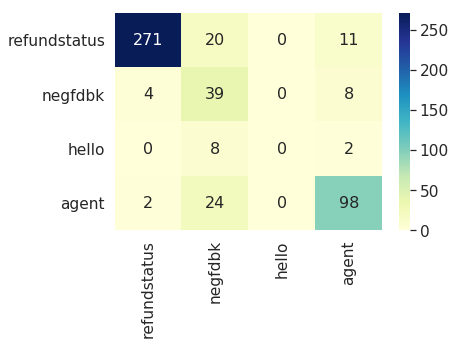

language: en acc: 0.9404517453798767


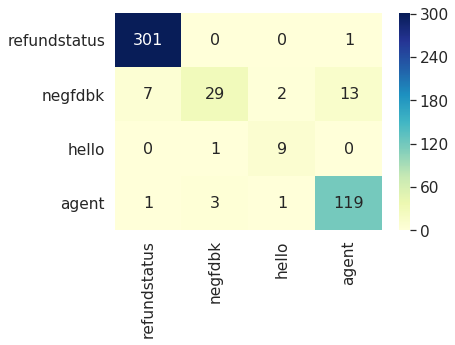

language: de acc: 0.7515400410677618


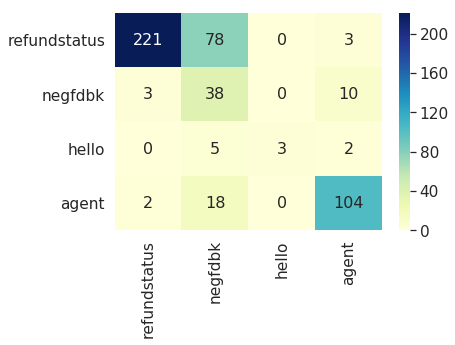

language: es acc: 0.8193018480492813


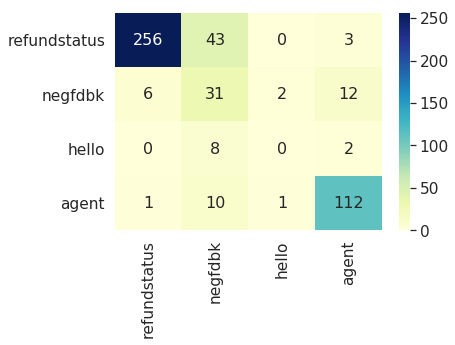

language: fr acc: 0.8562628336755647


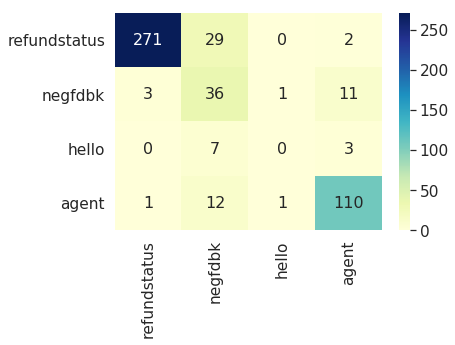

In [118]:

for k in matrix:
    print("language: " + k +" acc: " + str(results[k][0]))
    plot_cm(matrix[k])
    